Partition explainer: 128it [00:14,  2.74it/s]                         
Exact explainer: 128it [00:32,  2.74it/s]                         


50
59
68


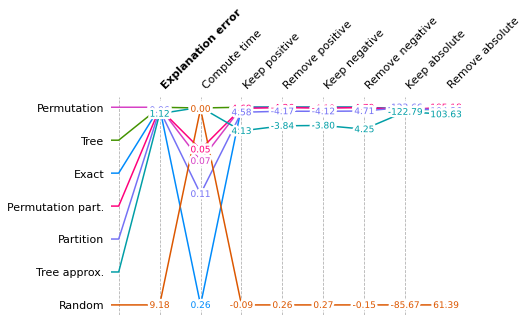

In [1]:
import xgboost
import shap
import shap.benchmark
from joblib import load
from sklearn.model_selection import train_test_split

import my_utils
from Shap.HandPD.Models.ETC_model import create_ETC

path_to_project = my_utils.path_to_project


def bench(is_need_to_create, model_filename):
    # X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
    X, y = shap.datasets.boston()
    X = X.values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

    # X_eval = X_test.values[:]
    X_eval = X_test[:]
    y_eval = Y_test[:]

    # if is_need_to_create:
    #     create_ETC(model_filename, X_train, Y_train)
    #
    # model = load(model_filename)
    model = xgboost.XGBRegressor(n_estimators=1000, subsample=0.3)
    model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], early_stopping_rounds=10, verbose=False)

    results = {}

    masker = shap.maskers.Independent(X_train)
    pmasker = shap.maskers.Partition(X_train)

    smasker = shap.benchmark.ExplanationError(
        masker, model.predict, X_eval
    )

    # build the explainers
    explainers = [
        ("Permutation", shap.explainers.Permutation(model.predict, masker)),
        ("Permutation part.", shap.explainers.Permutation(model.predict, pmasker)),
        ("Partition", shap.explainers.Partition(model.predict, pmasker)),
        ("Tree", shap.explainers.Tree(model, masker)),
        ("Tree approx.", shap.explainers.Tree(model, masker, approximate=True)),
        ("Exact", shap.explainers.Exact(model.predict, masker)),
        ("Random", shap.explainers.other.Random(model.predict, masker))
    ]

    attributions = [(name, exp(X_eval)) for name, exp in explainers]

    results["explanation error"] = [smasker(v, name=n) for n, v in attributions]

    ct = shap.benchmark.ComputeTime()
    results["compute time"] = [ct(v, name=n) for n, v in attributions]

    print(50)

    for mask_type, ordering in [("keep", "positive"), ("remove", "positive"), ("keep", "negative"),
                                ("remove", "negative")]:
        smasker = shap.benchmark.SequentialMasker(
            mask_type, ordering, masker, model.predict, X_eval
        )
        results[mask_type + " " + ordering] = [smasker(v, name=n) for n, v in attributions]

    print(59)

    cmasker = shap.maskers.Composite(masker, shap.maskers.Fixed())
    for mask_type, ordering in [("keep", "absolute"), ("remove", "absolute")]:
        smasker = shap.benchmark.SequentialMasker(
            mask_type, ordering, cmasker, lambda X, y: (y - model.predict(X)) ** 2, X_eval, y_eval
        )
        results[mask_type + " " + ordering] = [smasker(v, name=n) for n, v in attributions]

    print(68)

    shap.plots.benchmark(sum(results.values(), []), show=False)


create = True
ETC_model_filename = path_to_project + 'Models/ETC.joblib'

bench(create, ETC_model_filename)
